# UV map
- nii to vtk
    - nii2mesh
- vtk to obj
    - https://imagetostl.com/convert/file/vtk/to/obj
- UV map is computed from UV-mapper
    - https://www.uvmapper.com/downloads.html

# TODO
- 양쪽 해마 합치기


# Common Libraries

In [142]:
import os
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
import plotly.graph_objects as go
import nibabel as nb
from glob import glob

# Custom Libraries

In [143]:
import sys
sys.path.append("/home/seojin/Seojin_commonTool/Module")
sys.path.append("/home/seojin/Seojin_commonTool/Module/Brain_Surface/")

from plot_3d import draw_uv_map, show_non_interactive_mesh, show_mesh
from brain_mesh import show_stat_onUV, load_mesh, show_interactive_mesh
from sj_image_process import find_connected_components_faces
from sj_array import map_indicies
from surface_analysis import surface_profile_onUV

# Constants

In [128]:
mask_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/roi/mask"
lt_hippo_path = os.path.join(mask_dir_path, "lt_hippocampus_more.obj")
lt_hippo_uv_path = os.path.join(mask_dir_path, "lt_hippocampus_more_afterUVmap_planarZ.obj")

# Load Data

In [129]:
# Vertex & Faces
lt_hippo_mesh_info = load_mesh(lt_hippo_path)
lt_hippo_uv_mesh_info = load_mesh(lt_hippo_uv_path, type_ = "uv")

# Data
data_dir_path = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/Group/rsa/rdm/set/WholeSet/base_seqOnly/None/pattern_separation"
data_paths = sorted(glob(os.path.join(data_dir_path, "WholeSet_HP*")))


# Orientation

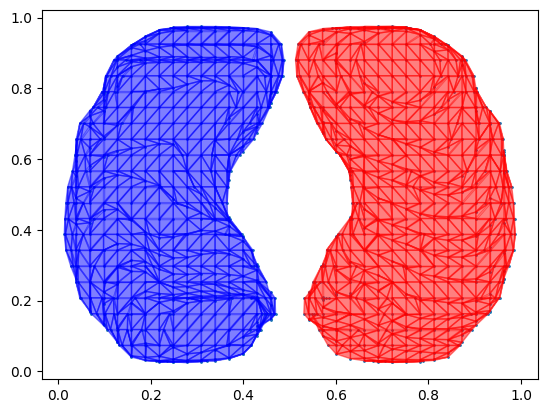

In [130]:
first_components = find_connected_components_faces(faces = lt_hippo_uv_mesh_info["face"])[0]
second_components = find_connected_components_faces(faces = lt_hippo_uv_mesh_info["face"])[1]
highlight_face_info = {
    "first" : {
        "data" : first_components,
        "color" : "red",
    },
    "second" : {
        "data" : second_components,
        "color" : "blue",
    },
}
draw_uv_map(lt_hippo_uv_mesh_info["uv"], lt_hippo_uv_mesh_info["face"], highlight_face_info = highlight_face_info)

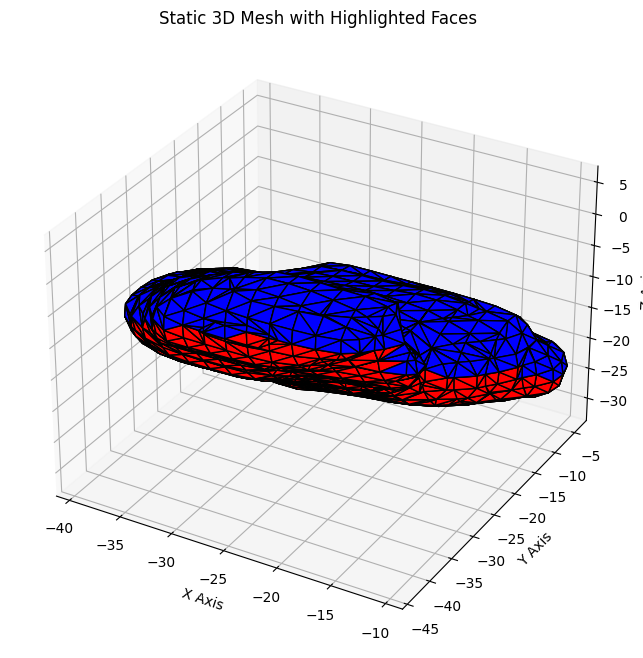

In [131]:
fig, ax = show_non_interactive_mesh(lt_hippo_mesh_info["vertex"], 
                                    lt_hippo_mesh_info["face"], 
                                    highlight_face_info = highlight_face_info)
fig.set_figwidth(10)
fig.set_figheight(15)
ax.set_xlabel("R+")
ax.set_ylabel("A+")
ax.set_zlabel("S+")
fig.tight_layout()
plt.show()

# Functions

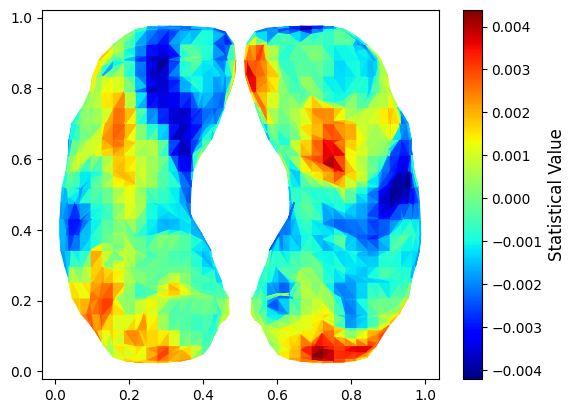

In [132]:
fig, axis = show_stat_onUV(vertices = lt_hippo_uv_mesh_info["vertex"], 
                           uv_coordinates = lt_hippo_uv_mesh_info["uv"],
                           faces = lt_hippo_uv_mesh_info["face"],
                           stat_path = data_paths[0])


# Remain superior only

In [133]:
superior_vertices = np.unique(lt_hippo_uv_mesh_info["face"][second_components].reshape(-1))

# Vertex index mapping
mapping = map_indicies(original_indices = np.arange(len(lt_hippo_uv_mesh_info["vertex"])), 
                       including_indices = superior_vertices)
mapping_df = pd.DataFrame({
    "original_index" : list(mapping.keys()),
    "converted_index" : list(mapping.values()),
    "x" : lt_hippo_uv_mesh_info["vertex"][:, 0],
    "y" : lt_hippo_uv_mesh_info["vertex"][:, 1],
    "z" : lt_hippo_uv_mesh_info["vertex"][:, 2],
})
inverse_mapping = {v: k for k, v in mapping.items()}
del inverse_mapping[-1]

# Change face based on vertex mapping
vectorized_function = np.vectorize(mapping.get)
coverted_faces = vectorized_function(lt_hippo_uv_mesh_info["face"])
coverted_faces = coverted_faces[np.alltrue(coverted_faces != -1, axis = 1)]

# Subset verticies
is_subset_vertices = np.array(list(mapping.values())) != -1
subset_vertices = lt_hippo_uv_mesh_info["vertex"][is_subset_vertices]
subset_uv_vertices = lt_hippo_uv_mesh_info["uv"][is_subset_vertices]


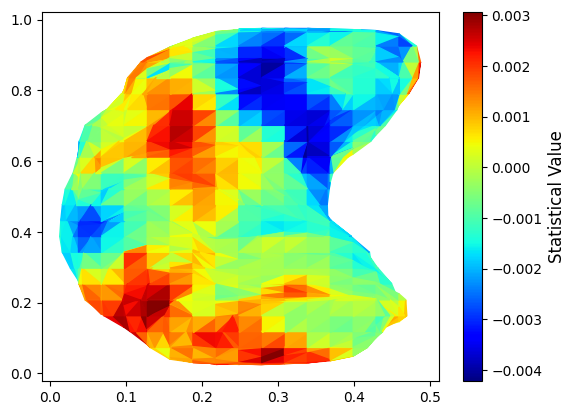

In [134]:
fig, axis = show_stat_onUV(vertices = subset_vertices, 
                           uv_coordinates = subset_uv_vertices,
                           faces = coverted_faces,
                           stat_path = data_paths[0])

# Coverage

In [135]:
result_info = surface_profile_onUV(data_paths = data_paths, 
                                    vertices = subset_vertices,
                                    uv_coordinates = subset_uv_vertices, 
                                    from_point = np.array([0.25, 0]), 
                                    to_point = np.array([0.25, 1]), 
                                    n_sampling = 10, 
                                    width = 0.1)

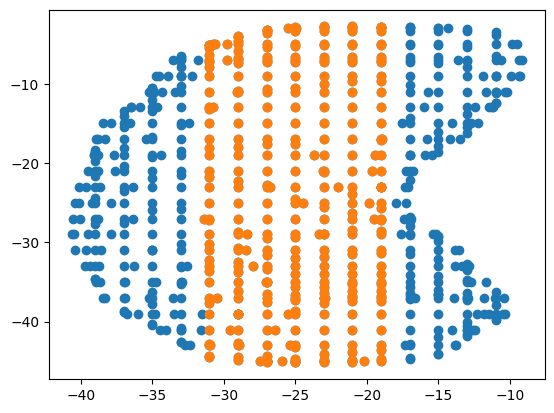

In [136]:
a = subset_vertices[result_info["virtual_strip_mask"]]

plt.scatter(subset_vertices[:, 0], subset_vertices[:, 1])
plt.scatter(a[:, 0], a[:, 1])

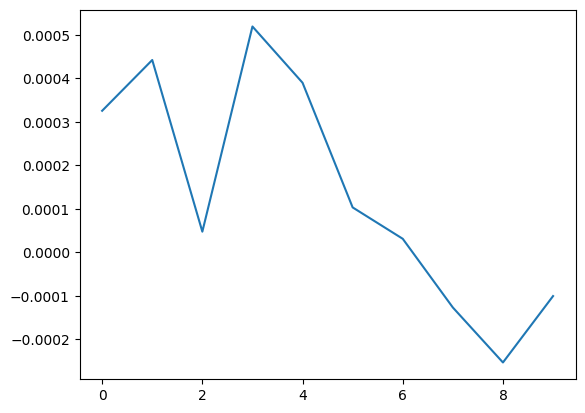

In [137]:
plt.plot(np.mean(result_info["sampling_datas"], axis = 0))

# Virtual strip

In [138]:
vectorized_function = np.vectorize(inverse_mapping.get)
highlight_vertex_indices = vectorized_function(np.where(result_info["virtual_strip_mask"])[0])

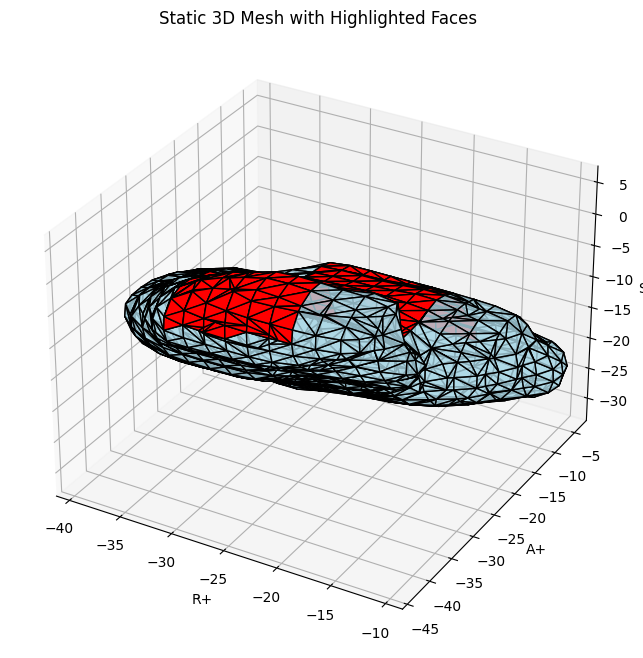

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': 'Static 3D Mesh with Highlighted Faces'}, xlabel='R+', ylabel='A+', zlabel='S+'>)

In [139]:
show_mesh(lt_hippo_uv_mesh_info["vertex"], 
          faces = lt_hippo_uv_mesh_info["face"],
          vertex_index_info = {
              "a" : {
                  "color" : "red",
                  "set" : highlight_vertex_indices,
              }
          })

In [140]:
is_highlight_face = np.alltrue(np.isin(lt_hippo_uv_mesh_info["face"], highlight_vertex_indices), axis = 1)
is_highlight_face_indices = np.where(is_highlight_face)[0]

In [141]:
show_interactive_mesh(vertices = lt_hippo_uv_mesh_info["vertex"],
                      faces = lt_hippo_uv_mesh_info["face"],
                      highlight_face_info = {
                          "name" : {
                              "color" : "red",
                              "data" : is_highlight_face_indices,
                          }
                      })